In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

import target_predicting_ML_functions_and_feature_ranking as functions
import RF_target_predicting_and_learning_curves_functions as tp_lc_functions

from scipy.optimize import curve_fit

In [2]:
df_14 = pd.read_csv('TNG300-SAM_images/v6_TNG300-SAM_Morphologies_definition/df_14_Normalized_as_defined_in_TNG300notebook_v6')
df_14_raw = pd.read_csv('TNG300-SAM_images/v6_TNG300-SAM_Morphologies_definition/df_14_Raw_as_defined_in_TNG300notebook_v6')
print("df_14.shape", df_14.shape)
print("df_14_raw.shape", df_14_raw.shape)

df_14.shape (158501, 38)
df_14_raw.shape (158501, 59)


In [3]:
import os
# os.mkdir('TNG300-SAM_images/v11_TNG300-SAM_df_14_Model_for_SReqn_Residuals')

#### Add a column for the predictions from the SR equation Spin/$NormVdisk^{2}$ and the Residuals of these predictions vs true values (for the Normalized Dataset only)

In [3]:
# Add the SR predicted equation as a column to the df
df_14.loc[:, 'SpinNormVdisk2_eqn'] = df_14.loc[:, 'HalopropSpin']/df_14.loc[:, 'GalpropNormVdisk']**2

In [4]:
# define Residuals
df_14.loc[:, 'Residuals'] = df_14.loc[:, 'GalpropNormHalfRadius'] - df_14.loc[:, 'SpinNormVdisk2_eqn']

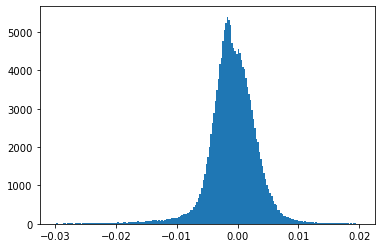

In [5]:
plt.hist(df_14.loc[:, 'Residuals'], bins=200, range=(-0.03, 0.02))
plt.show()

### <font color='purple'> <a id =2> </a> <br> Predicting Residuals (HalfmassRadius - Spin/NormVdisk2) for Groups 1-4: RF and Feature Ranking 

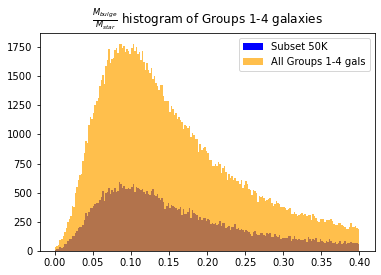

In [5]:
# choose a subsample of 50K galaxies since the original dataset is too large
df_14_sample = df_14.sample(n = 50000, random_state = 2023)

plt.hist(df_14_sample.BulgeMstar_ratio, color='blue', label='Subset 50K', range=(0.0,0.4), bins=200)
plt.hist(df_14.BulgeMstar_ratio,  color='orange', 
         label='All Groups 1-4 gals', alpha=0.7, range=(0.0,0.4), bins=200)
plt.title(r'$\frac{M_{bulge}}{M_{star}}$ histogram of Groups 1-4 galaxies')
plt.legend()
# plt.savefig('TNG300-SAM_images/v11_TNG300-SAM_df_14_Model_for_SReqn_Residuals/v11_df_14_BulgeMstar_ratio_histogram_all_vs_50kdataset.jpeg', dpi=500)
plt.show()

In [7]:
df_14_sample.columns.to_list()

['GalpropMaccdot_radio',
 'GalpropMstrip',
 'GalpropMu_merger',
 'GalpropOutflowRate_Mass',
 'GalpropOutflowRate_Metal',
 'GalpropSfr',
 'GalpropSfrave100myr',
 'GalpropSfrave1gyr',
 'GalpropSfrave20myr',
 'GalpropTmerger',
 'GalpropTmerger_major',
 'GalpropZcold',
 'GalpropZstar',
 'HalopropC_nfw',
 'HalopropMaccdot_pristine',
 'HalopropMaccdot_radio',
 'HalopropMaccdot_reaccreate',
 'HalopropMcooldot',
 'HalopropMetal_ejected',
 'HalopropZhot',
 'BulgeMstar_ratio',
 'DiskMstar_ratio',
 'GalpropNormHalfRadius',
 'GalpropNormMstar',
 'HalopropNormMhot',
 'GalpropNormMbulge',
 'GalpropNormMdisk',
 'GalpropNormMBH',
 'GalpropNormMH2',
 'GalpropNormMHI',
 'GalpropNormMHII',
 'GalpropNormMcold',
 'GalpropNormMstar_merge',
 'HalopropNormMass_ejected',
 'HalopropNormMstar_diffuse',
 'GalpropNormSigmaBulge',
 'GalpropNormVdisk',
 'HalopropSpin',
 'SpinNormVdisk2_eqn',
 'Residuals']

In [8]:
X_14_sample = df_14_sample.drop(columns=['GalpropNormHalfRadius', 'BulgeMstar_ratio',
                         'GalpropNormMdisk', 'DiskMstar_ratio', 'SpinNormVdisk2_eqn', 'Residuals',
                        'GalpropNormMH2', 'GalpropNormMHI', 'GalpropNormMHII', 'GalpropNormVdisk'  ])
 # Remove MH2, MHI and MHII because they are already contained in Mcold=(MH2+MHI+MHII); assuming our
 # initial model for Halfmass Radius captures all dependence on Vdisk, remove Vdisk for Residuals modelling

y_14_sample = df_14_sample.loc[:, 'Residuals']

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params, best score: 0.7207 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}
RF Accuracy: 0.72 (+/- 0.04)


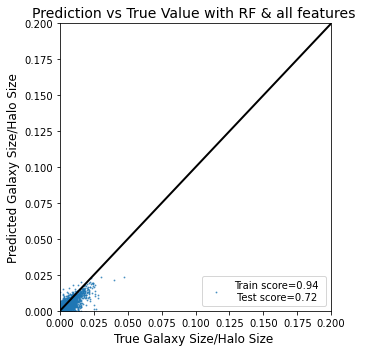

Elapsed time to compute the importances: 0.080 seconds
Elapsed time to compute the importances: 58.159 seconds


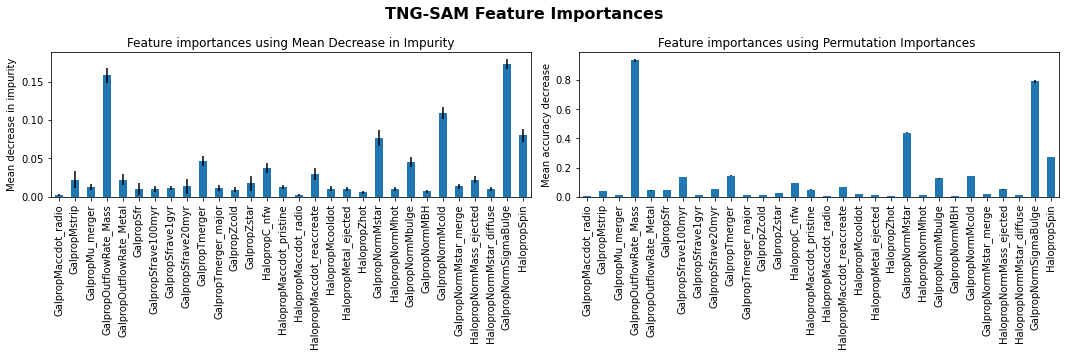

  0%|                                                    | 0/30 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▍                                          | 1/30 [00:02<01:10,  2.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|██▉                                         | 2/30 [00:12<03:07,  6.69s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▍                                       | 3/30 [00:24<04:10,  9.29s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 13%|█████▊                                      | 4/30 [00:35<04:18,  9.95s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▎                                    | 5/30 [00:45<04:12, 10.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 20%|████████▊                                   | 6/30 [00:56<04:03, 10.15s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|██████████▎                                 | 7/30 [01:06<03:53, 10.17s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|███████████▋                                | 8/30 [01:16<03:45, 10.25s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|█████████████▏                              | 9/30 [01:27<03:36, 10.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▎                            | 10/30 [01:35<03:15,  9.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 37%|███████████████▊                           | 11/30 [01:40<02:38,  8.35s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 40%|█████████████████▏                         | 12/30 [01:50<02:38,  8.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 43%|██████████████████▋                        | 13/30 [02:00<02:37,  9.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 47%|████████████████████                       | 14/30 [02:14<02:50, 10.66s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 15/30 [02:21<02:23,  9.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 53%|██████████████████████▉                    | 16/30 [02:24<01:45,  7.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████▎                  | 17/30 [02:34<01:46,  8.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 60%|█████████████████████████▊                 | 18/30 [02:43<01:42,  8.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 63%|███████████████████████████▏               | 19/30 [02:55<01:43,  9.40s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 20/30 [03:05<01:35,  9.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 70%|██████████████████████████████             | 21/30 [03:14<01:26,  9.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 73%|███████████████████████████████▌           | 22/30 [03:22<01:13,  9.17s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 77%|████████████████████████████████▉          | 23/30 [03:33<01:06,  9.49s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 80%|██████████████████████████████████▍        | 24/30 [03:35<00:44,  7.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|███████████████████████████████████▊       | 25/30 [03:47<00:43,  8.64s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 87%|█████████████████████████████████████▎     | 26/30 [03:56<00:34,  8.70s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|██████████████████████████████████████▋    | 27/30 [04:07<00:28,  9.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|████████████████████████████████████████▏  | 28/30 [04:13<00:16,  8.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 97%|█████████████████████████████████████████▌ | 29/30 [04:24<00:09,  9.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 30/30 [04:31<00:00,  9.06s/it]


1. iteration: 
	 1 GalpropNormSigmaBulge 0.1506724241589664


  0%|                                                    | 0/29 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▌                                          | 1/29 [00:19<09:03, 19.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|███                                         | 2/29 [00:38<08:41, 19.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▌                                       | 3/29 [00:56<08:04, 18.65s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 14%|██████                                      | 4/29 [01:12<07:20, 17.61s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▌                                    | 5/29 [01:28<06:52, 17.18s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 21%|█████████                                   | 6/29 [01:45<06:32, 17.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▌                                 | 7/29 [02:02<06:10, 16.82s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 28%|████████████▏                               | 8/29 [02:18<05:51, 16.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 31%|█████████████▋                              | 9/29 [02:35<05:33, 16.66s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 34%|██████████████▊                            | 10/29 [02:50<05:05, 16.10s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▎                          | 11/29 [03:03<04:33, 15.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|█████████████████▊                         | 12/29 [03:19<04:25, 15.63s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▎                       | 13/29 [03:38<04:26, 16.67s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▊                      | 14/29 [03:53<04:01, 16.12s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▏                    | 15/29 [04:07<03:34, 15.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████▋                   | 16/29 [04:26<03:34, 16.51s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▏                 | 17/29 [04:44<03:23, 16.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▋                | 18/29 [04:59<03:01, 16.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 66%|████████████████████████████▏              | 19/29 [05:15<02:42, 16.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 69%|█████████████████████████████▋             | 20/29 [05:34<02:34, 17.19s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 72%|███████████████████████████████▏           | 21/29 [05:52<02:18, 17.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▌          | 22/29 [06:11<02:04, 17.78s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|██████████████████████████████████         | 23/29 [06:29<01:46, 17.81s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|███████████████████████████████████▌       | 24/29 [06:45<01:27, 17.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|█████████████████████████████████████      | 25/29 [07:02<01:09, 17.30s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|██████████████████████████████████████▌    | 26/29 [07:20<00:51, 17.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|████████████████████████████████████████   | 27/29 [07:36<00:34, 17.11s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 97%|█████████████████████████████████████████▌ | 28/29 [07:53<00:17, 17.13s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 29/29 [08:10<00:00, 16.92s/it]


2. iteration: 
	 1 GalpropNormSigmaBulge 0.1506724241589664
	 2 GalpropOutflowRate_Mass 0.31667643276347335


  0%|                                                    | 0/28 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▌                                          | 1/28 [00:25<11:21, 25.25s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|███▏                                        | 2/28 [00:50<10:55, 25.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 11%|████▋                                       | 3/28 [01:15<10:30, 25.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 14%|██████▎                                     | 4/28 [01:40<10:04, 25.17s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 18%|███████▊                                    | 5/28 [02:05<09:38, 25.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 21%|█████████▍                                  | 6/28 [02:31<09:15, 25.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 25%|███████████                                 | 7/28 [02:56<08:52, 25.35s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▌                               | 8/28 [03:22<08:26, 25.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|██████████████▏                             | 9/28 [03:46<07:57, 25.15s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 36%|███████████████▎                           | 10/28 [04:09<07:18, 24.39s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|████████████████▉                          | 11/28 [04:36<07:05, 25.06s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 43%|██████████████████▍                        | 12/28 [05:03<06:49, 25.61s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 46%|███████████████████▉                       | 13/28 [05:29<06:26, 25.75s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 14/28 [05:50<05:44, 24.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 54%|███████████████████████                    | 15/28 [06:15<05:19, 24.59s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████▌                  | 16/28 [06:41<05:00, 25.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|██████████████████████████                 | 17/28 [07:06<04:34, 24.91s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 64%|███████████████████████████▋               | 18/28 [07:35<04:20, 26.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▏             | 19/28 [08:02<03:58, 26.45s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▋            | 20/28 [08:27<03:29, 26.19s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 75%|████████████████████████████████▎          | 21/28 [08:53<03:01, 25.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|█████████████████████████████████▊         | 22/28 [09:18<02:34, 25.73s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 82%|███████████████████████████████████▎       | 23/28 [09:42<02:06, 25.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|████████████████████████████████████▊      | 24/28 [10:08<01:41, 25.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 89%|██████████████████████████████████████▍    | 25/28 [10:33<01:15, 25.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|███████████████████████████████████████▉   | 26/28 [10:58<00:50, 25.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▍ | 27/28 [11:23<00:25, 25.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 28/28 [11:48<00:00, 25.29s/it]


3. iteration: 
	 1 GalpropNormSigmaBulge 0.1506724241589664
	 2 GalpropOutflowRate_Mass 0.31667643276347335
	 3 GalpropNormMcold 0.4402794564186907


  0%|                                                    | 0/27 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▋                                          | 1/27 [00:33<14:24, 33.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|███▎                                        | 2/27 [01:05<13:43, 32.94s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 11%|████▉                                       | 3/27 [01:37<12:56, 32.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▌                                     | 4/27 [02:11<12:35, 32.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▏                                   | 5/27 [02:41<11:40, 31.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 22%|█████████▊                                  | 6/27 [03:15<11:22, 32.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|███████████▍                                | 7/27 [03:47<10:51, 32.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|█████████████                               | 8/27 [04:21<10:27, 33.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▋                             | 9/27 [04:53<09:47, 32.62s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 37%|███████████████▉                           | 10/27 [05:23<09:01, 31.86s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|█████████████████▌                         | 11/27 [05:56<08:35, 32.25s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|███████████████████                        | 12/27 [06:30<08:09, 32.63s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▋                      | 13/27 [07:04<07:42, 33.06s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▎                    | 14/27 [07:36<07:04, 32.66s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|███████████████████████▉                   | 15/27 [08:10<06:36, 33.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▍                 | 16/27 [08:45<06:11, 33.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 63%|███████████████████████████                | 17/27 [09:18<05:36, 33.61s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 18/27 [09:53<05:04, 33.82s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 70%|██████████████████████████████▎            | 19/27 [10:22<04:19, 32.49s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 74%|███████████████████████████████▊           | 20/27 [10:56<03:50, 32.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 78%|█████████████████████████████████▍         | 21/27 [11:29<03:18, 33.13s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|███████████████████████████████████        | 22/27 [11:59<02:40, 32.04s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 85%|████████████████████████████████████▋      | 23/27 [12:32<02:09, 32.30s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 89%|██████████████████████████████████████▏    | 24/27 [13:05<01:37, 32.61s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|███████████████████████████████████████▊   | 25/27 [13:42<01:07, 33.75s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▍ | 26/27 [14:17<00:34, 34.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 27/27 [14:51<00:00, 33.00s/it]


4. iteration: 
	 1 GalpropNormSigmaBulge 0.1506724241589664
	 2 GalpropOutflowRate_Mass 0.31667643276347335
	 3 GalpropNormMcold 0.4402794564186907
	 4 GalpropTmerger 0.5440037604970072


  0%|                                                    | 0/26 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▋                                          | 1/26 [00:45<18:56, 45.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  8%|███▍                                        | 2/26 [01:31<18:20, 45.85s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████                                       | 3/26 [02:16<17:26, 45.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▊                                     | 4/26 [03:02<16:44, 45.65s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▍                                   | 5/26 [03:48<15:59, 45.71s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|██████████▏                                 | 6/26 [04:33<15:10, 45.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|███████████▊                                | 7/26 [05:21<14:40, 46.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 31%|█████████████▌                              | 8/26 [06:07<13:49, 46.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▏                            | 9/26 [06:42<12:05, 42.67s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▌                          | 10/26 [07:27<11:33, 43.35s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|██████████████████▏                        | 11/26 [08:11<10:55, 43.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 46%|███████████████████▊                       | 12/26 [08:55<10:14, 43.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 13/26 [09:36<09:16, 42.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 54%|███████████████████████▏                   | 14/26 [10:20<08:37, 43.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 58%|████████████████████████▊                  | 15/26 [11:04<07:59, 43.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▍                | 16/26 [11:48<07:15, 43.51s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|████████████████████████████               | 17/26 [12:32<06:34, 43.85s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 69%|█████████████████████████████▊             | 18/26 [13:17<05:52, 44.10s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 73%|███████████████████████████████▍           | 19/26 [14:01<05:09, 44.19s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 77%|█████████████████████████████████          | 20/26 [14:46<04:25, 44.30s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|██████████████████████████████████▋        | 21/26 [15:30<03:41, 44.38s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 85%|████████████████████████████████████▍      | 22/26 [16:08<02:49, 42.40s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|██████████████████████████████████████     | 23/26 [16:53<02:09, 43.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 92%|███████████████████████████████████████▋   | 24/26 [17:38<01:27, 43.70s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▎ | 25/26 [18:23<00:43, 43.96s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 26/26 [19:06<00:00, 44.11s/it]


5. iteration: 
	 1 GalpropNormSigmaBulge 0.1506724241589664
	 2 GalpropOutflowRate_Mass 0.31667643276347335
	 3 GalpropNormMcold 0.4402794564186907
	 4 GalpropTmerger 0.5440037604970072
	 5 HalopropC_nfw 0.5943951438514031


  0%|                                                    | 0/25 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▊                                          | 1/25 [00:51<20:43, 51.81s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  8%|███▌                                        | 2/25 [01:44<20:00, 52.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████▎                                      | 3/25 [02:36<19:08, 52.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 16%|███████                                     | 4/25 [03:28<18:15, 52.15s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 20%|████████▊                                   | 5/25 [04:21<17:31, 52.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▌                                 | 6/25 [05:14<16:40, 52.64s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 28%|████████████▎                               | 7/25 [06:06<15:45, 52.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|██████████████                              | 8/25 [06:59<14:53, 52.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 36%|███████████████▊                            | 9/25 [07:48<13:41, 51.35s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 40%|█████████████████▏                         | 10/25 [08:40<12:53, 51.59s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|██████████████████▉                        | 11/25 [09:32<12:04, 51.71s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▋                      | 12/25 [10:20<10:58, 50.63s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▎                    | 13/25 [11:12<10:11, 50.97s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|████████████████████████                   | 14/25 [12:05<09:26, 51.51s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 60%|█████████████████████████▊                 | 15/25 [12:56<08:35, 51.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 64%|███████████████████████████▌               | 16/25 [13:48<07:45, 51.73s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▏             | 17/25 [14:41<06:56, 52.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 72%|██████████████████████████████▉            | 18/25 [15:33<06:05, 52.15s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▋          | 19/25 [16:26<05:13, 52.25s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 80%|██████████████████████████████████▍        | 20/25 [17:19<04:21, 52.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 84%|████████████████████████████████████       | 21/25 [18:10<03:28, 52.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▊     | 22/25 [19:03<02:36, 52.29s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 92%|███████████████████████████████████████▌   | 23/25 [19:56<01:44, 52.44s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▎ | 24/25 [20:48<00:52, 52.35s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 25/25 [21:39<00:00, 51.99s/it]


6. iteration: 
	 1 GalpropNormSigmaBulge 0.1506724241589664
	 2 GalpropOutflowRate_Mass 0.31667643276347335
	 3 GalpropNormMcold 0.4402794564186907
	 4 GalpropTmerger 0.5440037604970072
	 5 HalopropC_nfw 0.5943951438514031
	 6 GalpropNormMstar 0.6308015490156137


  0%|                                                    | 0/24 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▊                                          | 1/24 [01:00<23:02, 60.11s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  8%|███▋                                        | 2/24 [02:00<22:10, 60.49s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████▌                                      | 3/24 [03:01<21:11, 60.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▎                                    | 4/24 [04:02<20:12, 60.63s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 21%|█████████▏                                  | 5/24 [05:03<19:18, 60.98s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 25%|███████████                                 | 6/24 [06:05<18:22, 61.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▊                               | 7/24 [07:06<17:21, 61.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▋                             | 8/24 [08:08<16:21, 61.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▌                           | 9/24 [09:05<14:58, 59.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|█████████████████▉                         | 10/24 [10:06<14:03, 60.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 46%|███████████████████▋                       | 11/24 [11:06<13:03, 60.25s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 12/24 [12:03<11:51, 59.25s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 54%|███████████████████████▎                   | 13/24 [13:03<10:55, 59.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 58%|█████████████████████████                  | 14/24 [14:05<10:01, 60.11s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▉                | 15/24 [15:05<09:01, 60.14s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 16/24 [16:06<08:02, 60.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▍            | 17/24 [17:07<07:04, 60.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 75%|████████████████████████████████▎          | 18/24 [18:08<06:04, 60.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|██████████████████████████████████         | 19/24 [19:09<05:04, 60.91s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|███████████████████████████████████▊       | 20/24 [20:10<04:03, 60.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▋     | 21/24 [21:11<03:02, 60.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 92%|███████████████████████████████████████▍   | 22/24 [22:12<02:01, 60.98s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▏ | 23/24 [23:13<01:00, 60.91s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 24/24 [24:13<00:00, 60.55s/it]


7. iteration: 
	 1 GalpropNormSigmaBulge 0.1506724241589664
	 2 GalpropOutflowRate_Mass 0.31667643276347335
	 3 GalpropNormMcold 0.4402794564186907
	 4 GalpropTmerger 0.5440037604970072
	 5 HalopropC_nfw 0.5943951438514031
	 6 GalpropNormMstar 0.6308015490156137
	 7 GalpropNormMbulge 0.6854078292436087


  0%|                                                    | 0/23 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▉                                          | 1/23 [01:08<25:17, 68.96s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  9%|███▊                                        | 2/23 [02:18<24:10, 69.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 13%|█████▋                                      | 3/23 [03:27<23:03, 69.19s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▋                                    | 4/23 [04:36<21:55, 69.25s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 22%|█████████▌                                  | 5/23 [05:46<20:51, 69.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|███████████▍                                | 6/23 [06:56<19:44, 69.66s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|█████████████▍                              | 7/23 [08:06<18:36, 69.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▎                            | 8/23 [09:16<17:27, 69.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|█████████████████▏                          | 9/23 [10:21<15:57, 68.39s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 43%|██████████████████▋                        | 10/23 [11:31<14:54, 68.79s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▌                      | 11/23 [12:40<13:45, 68.82s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▍                    | 12/23 [13:45<12:25, 67.74s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████▎                  | 13/23 [14:54<11:20, 68.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|██████████████████████████▏                | 14/23 [16:04<10:17, 68.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|████████████████████████████               | 15/23 [17:12<09:08, 68.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 70%|█████████████████████████████▉             | 16/23 [18:22<08:02, 68.90s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 74%|███████████████████████████████▊           | 17/23 [19:32<06:55, 69.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 78%|█████████████████████████████████▋         | 18/23 [20:42<05:46, 69.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|███████████████████████████████████▌       | 19/23 [21:50<04:36, 69.06s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 87%|█████████████████████████████████████▍     | 20/23 [23:00<03:27, 69.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 91%|███████████████████████████████████████▎   | 21/23 [24:09<02:18, 69.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▏ | 22/23 [25:19<01:09, 69.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 23/23 [26:27<00:00, 69.02s/it]


8. iteration: 
	 1 GalpropNormSigmaBulge 0.1506724241589664
	 2 GalpropOutflowRate_Mass 0.31667643276347335
	 3 GalpropNormMcold 0.4402794564186907
	 4 GalpropTmerger 0.5440037604970072
	 5 HalopropC_nfw 0.5943951438514031
	 6 GalpropNormMstar 0.6308015490156137
	 7 GalpropNormMbulge 0.6854078292436087
	 8 GalpropSfr 0.6987805615374164


  0%|                                                    | 0/22 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  5%|██                                          | 1/22 [01:17<27:13, 77.77s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  9%|████                                        | 2/22 [02:35<25:56, 77.85s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 14%|██████                                      | 3/22 [03:54<24:43, 78.10s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 18%|████████                                    | 4/22 [05:12<23:25, 78.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|██████████                                  | 5/22 [06:30<22:10, 78.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|████████████                                | 6/22 [07:49<20:52, 78.30s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|██████████████                              | 7/22 [09:07<19:32, 78.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 36%|████████████████                            | 8/22 [10:21<17:56, 76.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|██████████████████                          | 9/22 [11:39<16:46, 77.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▌                       | 10/22 [12:57<15:29, 77.45s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 11/22 [14:11<14:00, 76.40s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████▍                   | 12/22 [15:29<12:48, 76.85s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▍                 | 13/22 [16:47<11:36, 77.39s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 64%|███████████████████████████▎               | 14/22 [18:05<10:19, 77.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▎             | 15/22 [19:23<09:03, 77.71s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 73%|███████████████████████████████▎           | 16/22 [20:42<07:47, 77.97s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 77%|█████████████████████████████████▏         | 17/22 [22:00<06:30, 78.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 82%|███████████████████████████████████▏       | 18/22 [23:18<05:11, 77.94s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|█████████████████████████████████████▏     | 19/22 [24:36<03:54, 78.10s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 91%|███████████████████████████████████████    | 20/22 [25:50<02:33, 76.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 95%|█████████████████████████████████████████  | 21/22 [27:09<01:17, 77.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 22/22 [28:26<00:00, 77.56s/it]


9. iteration: 
	 1 GalpropNormSigmaBulge 0.1506724241589664
	 2 GalpropOutflowRate_Mass 0.31667643276347335
	 3 GalpropNormMcold 0.4402794564186907
	 4 GalpropTmerger 0.5440037604970072
	 5 HalopropC_nfw 0.5943951438514031
	 6 GalpropNormMstar 0.6308015490156137
	 7 GalpropNormMbulge 0.6854078292436087
	 8 GalpropSfr 0.6987805615374164
	 9 GalpropMstrip 0.7057863290505919


  0%|                                                    | 0/21 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  5%|██                                          | 1/21 [01:25<28:29, 85.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▏                                       | 2/21 [02:51<27:09, 85.78s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 14%|██████▎                                     | 3/21 [04:17<25:48, 86.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▍                                   | 4/21 [05:43<24:20, 85.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▍                                 | 5/21 [07:09<22:55, 85.95s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▌                               | 6/21 [08:35<21:28, 85.93s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▋                             | 7/21 [09:57<19:44, 84.59s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▊                           | 8/21 [11:23<18:25, 85.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 43%|██████████████████▊                         | 9/21 [12:49<17:04, 85.35s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▍                      | 10/21 [14:11<15:26, 84.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▌                    | 11/21 [15:36<14:06, 84.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████▌                  | 12/21 [17:03<12:47, 85.30s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▌                | 13/21 [18:28<11:22, 85.28s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 14/21 [19:55<09:59, 85.67s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▋            | 15/21 [21:21<08:34, 85.82s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▊          | 16/21 [22:47<07:09, 85.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|██████████████████████████████████▊        | 17/21 [24:12<05:42, 85.67s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|████████████████████████████████████▊      | 18/21 [25:39<04:18, 86.06s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|██████████████████████████████████████▉    | 19/21 [27:10<02:55, 87.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 95%|████████████████████████████████████████▉  | 20/21 [28:36<01:27, 87.14s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 21/21 [30:01<00:00, 85.79s/it]

10. iteration: 
	 1 GalpropNormSigmaBulge 0.1506724241589664
	 2 GalpropOutflowRate_Mass 0.31667643276347335
	 3 GalpropNormMcold 0.4402794564186907
	 4 GalpropTmerger 0.5440037604970072
	 5 HalopropC_nfw 0.5943951438514031
	 6 GalpropNormMstar 0.6308015490156137
	 7 GalpropNormMbulge 0.6854078292436087
	 8 GalpropSfr 0.6987805615374164
	 9 GalpropMstrip 0.7057863290505919
	 10 HalopropSpin 0.7090032534211362


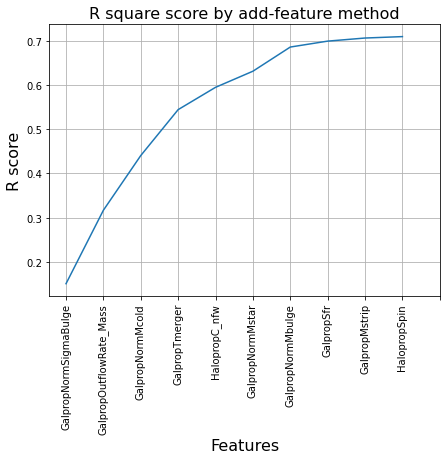

Elapsed time to run RF func on Group 14 with 50K galaxies to predict Residuals: 13027.307 seconds


In [9]:
# this code takes 14957.625 seconds ~ 4.2 hrs to run when the dataset is Groups 1-4 galaxies with 50,000 entries
# (out of a total 158,501) and 10 most important features
start_time = time.time()

RF_results_14 = functions.target_predicting_RF_function(X=X_14_sample, y=y_14_sample)

elapsed_time = time.time() - start_time

print(f"Elapsed time to run RF func on Group 14 with 50K galaxies to predict Residuals: {elapsed_time:.3f} seconds")

##### RF best parameters for predicting Residuals in Disk Galaxies (Groups 1-4), Galaxies with $\frac{M_{bulge}}{M_{star}}$<=0.4:

    Fitting 5 folds for each of 27 candidates, totalling 135 fits
    Best params, best score: 0.7326 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}
    RF Accuracy: 0.72 (+/- 0.05)
(The above code takes 3779.517 seconds ~ 1 hr to run when the dataset is Groups 1-4 galaxies with 15K entries)

    Fitting 5 folds for each of 27 candidates, totalling 135 fits
    Best params, best score: 0.7857 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}
    RF Accuracy: 0.78 (+/- 0.03)
(The above code takes 14957.625 seconds ~ 4.5 hrs to run when the dataset is Groups 1-4 galaxies with 50K entries)

 <font color='purple'>Fitting 5 folds for each of 27 candidates, totalling 135 fits
    Best params, best score: 0.7207 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}
    RF Accuracy: 0.72 (+/- 0.04)
    
(The above code takes 14957.625 seconds ~ 4.5 hrs to run when the dataset is Groups 1-4 galaxies with 50K entries, dataset where features MHI, MHII and MH2, as well NormVdisk are removed)

#### The most important features for predicting Residuals (15K) Dataset Disk Galaxies (Groups 1-4) galaxies are: 

	 1 GalpropNormSigmaBulge 0.14097072799256397
	 2 GalpropNormVdisk 0.36411062778932246
	 3 GalpropNormMHI 0.4586528269696443
	 4 GalpropTmerger 0.5391956269894024
	 5 GalpropNormMH2 0.6428269667331211
	 6 HalopropC_nfw 0.6867558621858164
	 7 GalpropNormMbulge 0.7039558486512232
	 8 GalpropNormMstar 0.7275286580715253
	 9 GalpropNormMHII 0.7437314601337359
	 10 HalopropSpin 0.7529752329234679

#### The most important features for predicting Residuals (50K) Dataset Disk Galaxies (Groups 1-4) galaxies are: 

	 1 GalpropNormSigmaBulge 0.150770783081107
	 2 GalpropNormVdisk 0.3674208531374876
	 3 GalpropNormMHI 0.4773508332395789
	 4 GalpropNormMH2 0.5579481566455811
	 5 GalpropTmerger 0.6759292993701796
	 6 HalopropC_nfw 0.7207586800166718
	 7 GalpropNormMbulge 0.7404782468353291
	 8 GalpropNormMstar 0.7852673555023406
	 9 HalopropSpin 0.7911843594797126
	 10 HalopropZhot 0.7956029052195563
     
#### <font color='purple'> The most important features for predicting Residuals (50K) Dataset Disk Galaxies (Groups 1-4) galaxies when MH2, MHI and MHII, as well as NormVdisk are removed from feature space are: 

     1 GalpropNormSigmaBulge 0.1506724241589664
	 2 GalpropOutflowRate_Mass 0.31667643276347335
	 3 GalpropNormMcold 0.4402794564186907
	 4 GalpropTmerger 0.5440037604970072
	 5 HalopropC_nfw 0.5943951438514031
	 6 GalpropNormMstar 0.6308015490156137
	 7 GalpropNormMbulge 0.6854078292436087
	 8 GalpropSfr 0.6987805615374164
	 9 GalpropMstrip 0.7057863290505919
	 10 HalopropSpin 0.7090032534211362

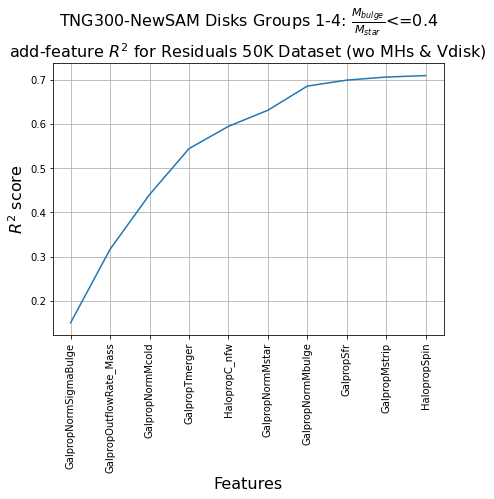

In [10]:
group14_fig_add_feature=RF_results_14[4].plot(x='features', y='r_sq_score', rot=90, figsize=(7,5), use_index=True,
                    legend=False, grid=True, 
                    xticks=range(0,10))
group14_fig_add_feature.set_title(label= r'TNG300-NewSAM Disks Groups 1-4: $\frac{M_{bulge}}{M_{star}}$<=0.4' + '\n' + r'add-feature $R^{2}$ for Residuals 50K Dataset (wo MHs & Vdisk)',fontsize=16)
group14_fig_add_feature.set_xlabel('Features',fontsize=16)
group14_fig_add_feature.set_ylabel(r'$R^{2}$ score',fontsize=16)

# group14_fig_add_feature.get_figure().savefig('TNG300-SAM_images/v11_TNG300-SAM_df_14_Model_for_SReqn_Residuals/v11_TNG300_Group_14_Residuals_R_score_by_add_feature_method_50Kdataset_woMHsVdisk.jpg', dpi=500)

plt.show()

In [11]:
# RF_results_14[4].to_csv('TNG300-SAM_images/v11_TNG300-SAM_df_14_Model_for_SReqn_Residuals/v11_TNG300_Residuals_Group_14_Max_r_scores_by_add_column_method_50Kdataset_woMHsVdisk.csv', index=False)

group14 = pd.read_csv('TNG300-SAM_images/v11_TNG300-SAM_df_14_Model_for_SReqn_Residuals/v11_TNG300_Residuals_Group_14_Max_r_scores_by_add_column_method_50Kdataset_woMHsVdisk.csv')

group14_fig = RF_results_14[1]
# group14_fig.savefig('TNG300-SAM_images/v11_TNG300-SAM_df_14_Model_for_SReqn_Residuals/v11_TNG300_Residuals_Group_14_RF_Prediction_vs_True_50Kdataset_woMHsVdisk.jpeg', dpi=500)
plt.show()

group14_fig_builtin_imp = RF_results_14[2]
# group14_fig_builtin_imp.savefig('TNG300-SAM_images/v11_TNG300-SAM_df_14_Model_for_SReqn_Residuals/v11_TNG300_Residuals_Group_14_Built_in_Feature_Ranking_50Kdataset_woMHsVdisk.jpeg', dpi=500)
plt.show()

In [3]:
# y_pred_RF_df_14 = RF_results_14[0]
# y_pred_RF_df_14 = pd.DataFrame({'y_pred_RF Residuals Group 14 \n 50K Dataset wo MHs & Vdisk': y_pred_RF_df_14})

# y_pred_RF_df_14.to_csv('TNG300-SAM_images/v11_TNG300-SAM_df_14_Model_for_SReqn_Residuals/v11_TNG300-NewSAM_Residuals_Group_14_y_pred_RF_predicted_sizes_50Kdataset_woMHsVdisk.csv', index=False)

y_pred_RF_14 = pd.read_csv('TNG300-SAM_images/v11_TNG300-SAM_df_14_Model_for_SReqn_Residuals/v11_TNG300-NewSAM_Residuals_Group_14_y_pred_RF_predicted_sizes_50Kdataset_woMHsVdisk.csv')

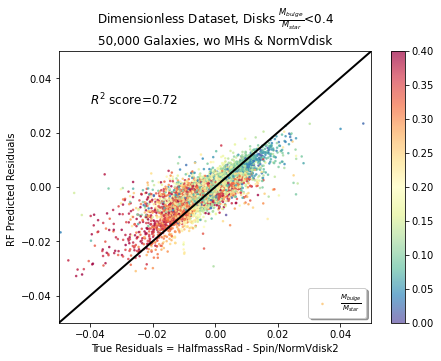

In [13]:
r2_score_disks_res=r2_score(df_14_sample.loc[:, 'Residuals'], y_pred_RF_df_14)

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_14_sample.loc[:, 'Residuals'], y_pred_RF_df_14,
            c = df_14_sample.loc[:, 'GalpropNormMbulge']/df_14_sample.loc[:,'GalpropNormMstar'], 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$\frac{M_{bulge}}{M_{star}}$', vmin=0.0, vmax=0.4)
ax.text(-0.04, 0.03, r'$R^{2}$ score=' + '{:.2f}'.format(r2_score_disks_res), size=12)
ax.axis([-0.05,0.05, -0.05,0.05])
ax.plot([-0.05, 0.05], [-0.05, 0.05], color = 'black', linewidth = 2)
ax.set_title(r'Dimensionless Dataset, Disks $\frac{M_{bulge}}{M_{star}}$<0.4' + '\n'+ r'50,000 Galaxies, wo MHs & NormVdisk')
ax.set_xlabel('True Residuals = HalfmassRad - Spin/NormVdisk2')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('RF Predicted Residuals ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG300-SAM_images/v11_TNG300-SAM_df_14_Model_for_SReqn_Residuals/v11_Group14_Predicted_vs_True_Residuals_dimensionless_50Kdataset_woMHsVdisk.jpeg', dpi=500)
plt.show()

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params, best score: 0.7206 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}
RF Accuracy: 0.72 (+/- 0.04)


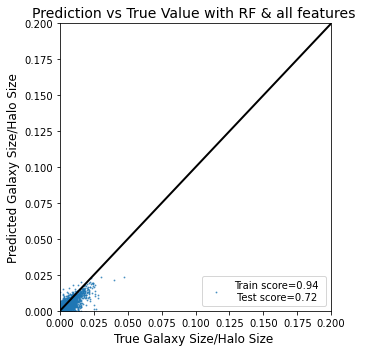

Elapsed time to compute the importances: 0.033 seconds
Elapsed time to compute the importances: 57.416 seconds


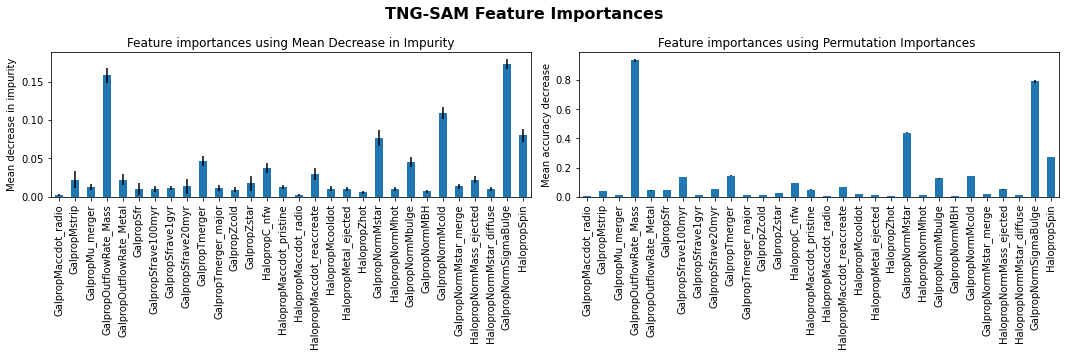

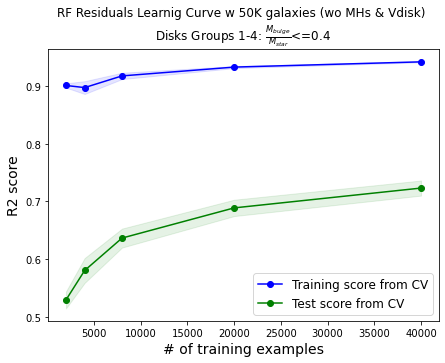

Elapsed time to run RF func and Learning Curves on Group 14 (B/M<=0.4): 1796.798 seconds


In [14]:
# this code takes 483.265 seconds ~ 8min to run when the dataset is Groups 1-4 galaxies with 15,000 entries
# this code takes 2035.614 seconds ~ 33min to run when the dataset is Groups 1-4 galaxies with 15,000 entries

start_time = time.time()

RF_lc_14 = tp_lc_functions.target_predicting_RF_function(X_14_sample, y_14_sample, 'RF Residuals Learnig Curve w 50K galaxies (wo MHs & Vdisk) \n' + r'Disks Groups 1-4: $\frac{M_{bulge}}{M_{star}}$<=0.4')

elapsed_time = time.time() - start_time

print(f"Elapsed time to run RF func and Learning Curves on Group 14 (B/M<=0.4): {elapsed_time:.3f} seconds")

In [15]:
lc_14 = RF_lc_14[4]
# lc_14.savefig('TNG300-SAM_images/v11_TNG300-SAM_df_14_Model_for_SReqn_Residuals/v11_TNG300_Group_14_RF_Residuals_Learning_Curve_50Kdataset_woMHsVdisk.jpeg', dpi=500)

### <font color='purple'> <a id =3> </a> <br> Performance Eqn = Spin/Norm$Vdisk^{2}$ + $Residuals_{RFpredicted}$ for Groups 1-4

Adjust the two columns to match type, so that they can be added

In [16]:
y_pred_RF_14.values.shape

(50000, 1)

In [7]:
y_pred_SR = df_14_sample.loc[:, 'HalopropSpin']/df_14_sample.loc[:, 'GalpropNormVdisk']**2

In [17]:
np.array(y_pred_SR)

(50000,)

In [18]:
y_pred_SR_df_14 = pd.DataFrame({'y_pred_SR \n 50K Dataset wo MHs & Vdisk': y_pred_SR})


In [19]:
y_pred_SR_df_14 .shape

(50000, 1)

In [29]:
y_pred_SR_df_14.loc[:, 'y_pred_SR \n 50K Dataset wo MHs & Vdisk'].values

array([0.08222881, 0.04350531, 0.02968735, ..., 0.02262715, 0.018942  ,
       0.0428867 ])

In [30]:
y_pred_RF_14.loc[:, 'y_pred_RF Residuals Group 14 \n 50K Dataset wo MHs & Vdisk'].values

array([ 0.00055496,  0.00047032,  0.0010275 , ...,  0.00020893,
       -0.00033865, -0.00132674])

In [31]:
y_pred_RF_14.loc[:, 'y_pred_RF Residuals Group 14 \n 50K Dataset wo MHs & Vdisk'].values + y_pred_SR_df_14.loc[:, 'y_pred_SR \n 50K Dataset wo MHs & Vdisk'].values

array([0.08278378, 0.04397563, 0.03071485, ..., 0.02283608, 0.01860335,
       0.04155996])

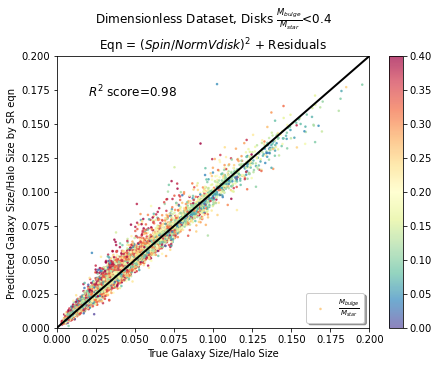

In [34]:
# Performance of (Spin/NormVdisk2 + Residuals)

eqn_w_residuals = y_pred_SR_df_14.loc[:, 'y_pred_SR \n 50K Dataset wo MHs & Vdisk'].values +  \
                  y_pred_RF_14.loc[:, 'y_pred_RF Residuals Group 14 \n 50K Dataset wo MHs & Vdisk'].values
#                   (df_14.loc[:, 'GalpropNormSigmaBulge'] + df_14.loc[:, 'GalpropOutflowRate_Mass'] + \
#                   df_14.loc[:, 'GalpropNormMcold'] + df_14.loc[:, 'GalpropTmerger'] + \
#                   df_14.loc[:, 'HalopropC_nfw'] + df_14.loc[:, 'GalpropNormMstar'] + \
#                   df_14.loc[:, 'GalpropNormMbulge'] + df_14.loc[:, 'GalpropSfr'] + \
#                   df_14.loc[:, 'GalpropMstrip'] + df_14.loc[:, 'HalopropSpin'])

r2_score_eqn_w_residuals=r2_score(df_14_sample.loc[:, 'GalpropNormHalfRadius'], eqn_w_residuals)

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_14_sample.loc[:, 'GalpropNormHalfRadius'], eqn_w_residuals,
            c = df_14_sample.loc[:, 'GalpropNormMbulge']/df_14_sample.loc[:,'GalpropNormMstar'], 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$\frac{M_{bulge}}{M_{star}}$', vmin=0.0, vmax=0.4)
ax.text(0.02, 0.17, r'$R^{2}$ score=' + '{:.2f}'.format(r2_score_eqn_w_residuals), size=12)
ax.axis([0.0,0.2, 0.0,0.2])
ax.plot([0.0, 0.3], [0.0, 0.3], color = 'black', linewidth = 2)
ax.set_title(r'Dimensionless Dataset, Disks $\frac{M_{bulge}}{M_{star}}$<0.4' + '\n'+ r'Eqn = $(Spin/NormVdisk)^{2}$ + Residuals')
ax.set_xlabel('True Galaxy Size/Halo Size')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Galaxy Size/Halo Size by SR eqn ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG300-SAM_images/v11_TNG300-SAM_df_14_Model_for_SReqn_Residuals/v11_Group14_SR_wResiduals_dimensionless.jpeg', dpi=500)
plt.show()

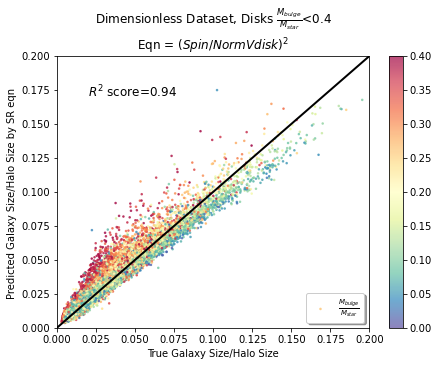

In [36]:
# Performance of (Spin/NormVdisk2 + Residuals)

eqn_w_residuals = y_pred_SR_df_14.loc[:, 'y_pred_SR \n 50K Dataset wo MHs & Vdisk'].values 

#                   (df_14.loc[:, 'GalpropNormSigmaBulge'] + df_14.loc[:, 'GalpropOutflowRate_Mass'] + \
#                   df_14.loc[:, 'GalpropNormMcold'] + df_14.loc[:, 'GalpropTmerger'] + \
#                   df_14.loc[:, 'HalopropC_nfw'] + df_14.loc[:, 'GalpropNormMstar'] + \
#                   df_14.loc[:, 'GalpropNormMbulge'] + df_14.loc[:, 'GalpropSfr'] + \
#                   df_14.loc[:, 'GalpropMstrip'] + df_14.loc[:, 'HalopropSpin'])

r2_score_eqn_w_residuals=r2_score(df_14_sample.loc[:, 'GalpropNormHalfRadius'], eqn_w_residuals)

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_14_sample.loc[:, 'GalpropNormHalfRadius'], eqn_w_residuals,
            c = df_14_sample.loc[:, 'GalpropNormMbulge']/df_14_sample.loc[:,'GalpropNormMstar'], 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$\frac{M_{bulge}}{M_{star}}$', vmin=0.0, vmax=0.4)
ax.text(0.02, 0.17, r'$R^{2}$ score=' + '{:.2f}'.format(r2_score_eqn_w_residuals), size=12)
ax.axis([0.0,0.2, 0.0,0.2])
ax.plot([0.0, 0.3], [0.0, 0.3], color = 'black', linewidth = 2)
ax.set_title(r'Dimensionless Dataset, Disks $\frac{M_{bulge}}{M_{star}}$<0.4' + '\n'+ r'Eqn = $(Spin/NormVdisk)^{2}$')
ax.set_xlabel('True Galaxy Size/Halo Size')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Galaxy Size/Halo Size by SR eqn ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG300-SAM_images/v11_TNG300-SAM_df_14_Model_for_SReqn_Residuals/v11_Group14_SR_dimensionless.jpeg', dpi=500)
plt.show()

### <font color='purple'> <a id =3> </a> <br> SR eqn search for Residuals of Groups 1-4

Adding the Residuals to the eqn Spin/NormVdisk2 improves the predictions of the equation drastically; the R2 score goes from 0.94 to 0.98; the spread in the predictions decreases. Next, can we come up with an equation form for Residuals? Use SR to search for an eqn, run file SR_TNG300-NewSAM_eqn_search_for_Residuals_of_Groups14_disk_galaxies_v1.py in terminal.

In [38]:
sr_v1_run1 = pd.read_csv('/Users/festabu/Desktop/ML_galaxy_size_project/Codes/TNG300-SAM_images/SR_Residuals_df_14_run1_disks_eqn_search/hall_of_fame_2023-05-03_140117.798.csv', sep = '|')

In [39]:
for i in range(14):
    print (sr_v1_run1.loc[i, 'Equation'])

-0.00081670296
(GalpropOutflowRate_Mass * -0.00016158099)
(GalpropOutflowRate_Mass * (GalpropNormSigmaBulge * -0.00015936546))
((GalpropOutflowRate_Mass + square(GalpropNormSigmaBulge)) * -0.00015844945)
((GalpropNormSigmaBulge - pow(0.49027407, GalpropSfr)) * -0.0038144724)
((pow(HalopropSpin, GalpropNormSigmaBulge) - (GalpropNormMcold / 0.22124834)) * 0.05070905)
(((pow(HalopropSpin, GalpropNormSigmaBulge) - (GalpropNormMcold / 0.25195462)) - GalpropNormMstar) * 0.048474133)
((pow(HalopropSpin, GalpropNormSigmaBulge) - ((GalpropNormMcold / 0.3740693) + (0.519578 / HalopropC_nfw))) * 0.06879635)
((pow(HalopropSpin, GalpropNormSigmaBulge) - ((GalpropNormMcold / 0.35555178) + ((0.46516004 / HalopropC_nfw) + GalpropNormMbulge))) * 0.06752368)
((pow(HalopropSpin, GalpropNormSigmaBulge) - ((GalpropNormMcold / 0.3608612) + (((GalpropNormMbulge / 0.3608612) / HalopropC_nfw) / GalpropNormMstar))) * 0.06752368)
((pow(HalopropSpin, GalpropNormSigmaBulge) - ((GalpropNormMcold / 0.35501415) + (((

In [40]:
sr_v1_run2 = pd.read_csv('/Users/festabu/Desktop/ML_galaxy_size_project/Codes/TNG300-SAM_images/SR_Residuals_df_14_run2_disks_eqn_search/hall_of_fame_2023-05-03_153221.834.csv', sep='|')

In [41]:
for i in range(14):
    print (sr_v1_run2.loc[i, 'Equation'])

-0.00081700826
(GalpropOutflowRate_Mass * -0.000161581)
(-0.0074123666 - (-0.0054756 / GalpropNormSigmaBulge))
(-0.0052261967 - (-0.0061197923 / (GalpropSfr + GalpropNormSigmaBulge)))
(-0.004354537 - (-0.0042303745 / (GalpropSfr + square(GalpropNormSigmaBulge))))
((0.96098346 - (pow(-0.9340445, GalpropOutflowRate_Mass) / GalpropNormSigmaBulge)) * -0.0067287483)
((0.7784117 - (pow(HalopropSpin - GalpropNormMcold, GalpropNormSigmaBulge) * HalopropC_nfw)) * -0.005150396)
((0.52791095 - ((pow(HalopropSpin - GalpropNormMcold, GalpropNormSigmaBulge) - GalpropNormMcold) * HalopropC_nfw)) * -0.0058522443)
(((((GalpropNormMcold / 0.0033861867) - (HalopropC_nfw / square(GalpropNormSigmaBulge))) * HalopropSpin) + 0.73312) * -0.005469439)
(((pow(-0.8844127, GalpropTmerger) - -0.40286046) - (pow(HalopropSpin - GalpropNormMcold, GalpropNormSigmaBulge) * HalopropC_nfw)) * -0.0052905725)
((((GalpropOutflowRate_Mass - (33.333195 - ((GalpropNormSigmaBulge / square(GalpropNormMstar)) * GalpropNormMbulge)

In [ ]:
-0.003*GalpropNormSigmaBulge - 0.003*HalopropSpin*(GalpropNormMbulge*GalpropNormSigmaBulge/GalpropNormMstar**2 + GalpropOutflowRate_Mass - 33.333195)